In [1]:
include("../scripts/ideal_robot.jl")

In [2]:
using Distributions
using Random

In [3]:
mutable struct Robot <: AbstractRobot
    pose
    r
    color
    agent
    poses
    sensor
    noise_pdf
    distance_until_noise
    theta_noise
    bias_rate_nu
    bias_rate_omega
    stuck_pdf
    escape_pdf
    time_until_stuck
    time_until_escape
    is_stuck
end


In [6]:
function Robot(pose, agent, sensor, color, noise_per_meter = 5, noise_std=pi/60,
    bias_rate_stds=(0.1,0.1), expected_stuck_time=1e100, expected_escape_time = 1e-100)
    rbt = Robot(ntuple(x->nothing, fieldcount(Robot))...)
    rbt.pose = pose
    rbt.r = 0.2
    rbt.agent = agent
    rbt.sensor = sensor
    rbt.poses = [pose]
    rbt.color = color
    rbt.noise_pdf = Exponential(1.0/(1e-100 + noise_per_meter))
    rbt.distance_until_noise = rand(rbt.noise_pdf)
    rbt.theta_noise = Normal(0, noise_std)
    rbt.bias_rate_nu = rand(Normal(1, bias_rate_stds[1]))
    rbt.bias_rate_omega = rand(Normal(1, bias_rate_stds[2]))
    rbt.stuck_pdf = Exponential(expected_stuck_time)
    rbt.escape_pdf = Exponential(expected_escape_time)
    rbt.time_until_stuck = rand(rbt.stuck_pdf)
    rbt.time_until_escape = rand(rbt.escape_pdf)
    rbt.is_stuck = false
    
    return rbt
end

Robot

In [8]:
function noise(self::Robot, pose, nu, omega, time_interval)
    self.distance_until_noise -= abs(nu)*time_interval + self.r*abs(omega)*time_interval
    if self.distance_until_noise <= 0.0
        self.distance_until_noise += rand(self.noise_pdf)
        pose[3] += rand(self.theta_noise)
    end
    return pose
end

noise (generic function with 1 method)

In [9]:
function bias(self::Robot, nu, omega)
    return nu*self.bias_rate_nu, omega*self.bias_rate_omega
end

bias (generic function with 1 method)

In [20]:
function stuck(self::Robot, nu, omega, time_interval)
    if self.is_stuck
        self.time_until_escape -= time_interval
        if self.time_until_escape <= 0.0
            self.time_until_escape += rand(self.escape_pdf)
            self.is_stuck = false
        end
    else
        self.time_until_stuck -= time_interval
        if self.time_until_stuck <= 0.0
            self.time_until_stuck += rand(self.stuck_pdf)
            self.is_stuck = true
        end
    end
    return nu*(!self.is_stuck), omega*(!self.is_stuck)
end

stuck (generic function with 1 method)

In [21]:
function one_step(self::Robot, time_interval)
    if isnothing(self.agent)
        return
    end
    obs = nothing
    if !isnothing(self.sensor)
        obs = data(self.sensor, self.pose)
    end
    nu, omega = decision(self.agent, obs)
    nu, omega = bias(self, nu, omega)
    nu, omega = stuck(self, nu, omega, time_interval)
    self.pose = state_transition(self, nu, omega, time_interval)
    self.pose = noise(self, self.pose, nu, omega, time_interval)
end

one_step (generic function with 3 methods)

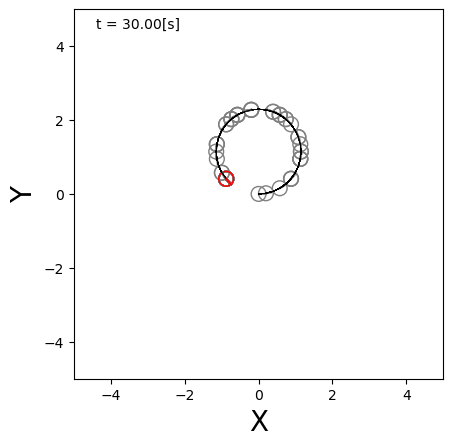

In [27]:
world = World(30, 1.0)
for i in 1:100
    circling = Agent(0.2, 10.0/180*pi)
    r = Robot([0.0,0.0,0.0], circling, nothing, "gray", 0.0, 0.0 , (0.0, 0.0), 60.0, 60.0)
    append(world, r)
end

r = IdealRobot([0.0, 0.0, 0.0], circling, nothing, "red")
append(world, r)

draw(world)

In [28]:
showanim("test.mp4")

<video controls src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAAcSRtZGF0AAACoAYF//+c3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE1NyAtIEguMjY0L01QRUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMTggLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xMiBsb29rYWhlYWRfdGhyZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MSBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAADfRliIQAF//+99S3zLLtU2+2C6j3op4mX0N1JQGblsTtOoAAAAMAAAMAAB68FzgCX4kK868AAAMAyoAXqEn/CmOPiA7BC5NJlvfhKIWPSXi/zA6JYDLoQAMQkginty7NGv2twoUk3+x++sOjYLO23GkLnX3zZEYn6a9vQcRQLf67K7SBvVrJ/o4DfjcfmL80ItpTpOBk9UoqIRYyXX9Jp26SG/qkhzXvDYJnUDUkXMWTV9xgIkId/B0DL63tzWtJoDT3qBLshsubVeON8CDX6ibsLgVVQ4A0D7tGbVkDzT/KsUAH7fA8ber7HvEJfThyzrLkSWNw9QjQzXk0jYHioNxDFOC0u5P/6flbarG27qxKpcR1g3jAe/uyNQkdibir9L1oZNoxCL9nTz5Do7WCxbfdwBz786P6Gt3+a9qFmQoe2Qlbs6zkxnOY8FmvubMXtnqJ20rtvpHrl79t6nq8q+9ZGR6BdRh00t3Aigy2K6jkGX8xF2NbE0107yMuMhNJ8nLf3bEUDA1W0TIui6TwnLCPxsZoeNH9a4AHuu+fRe2d9XIIXx50n+Od5FnEb6C9gPt3e826oHE1AgcXxvRCBxQI/BeMobygLn0j9VWXolTLRr1nefL0lQJDHRd0bMQ2bwJ+rzm8Mp/b24dtpJKsQryCKzCJcKad8rXWcKOAUajWn2P0NKgXGBFwI0M+idp/QrLQJJggEup5GqdX9LpivTz0Tg/GtPHRN/r0yThMt621zn7a4ylSl42LRaw5MezwM/+4GZwzEqm3AEN61OX4+ROEd9aArigTp3XWPCo1M3arBFgwglcnHb1e8ZbqIj4YaLbonxrArOWHmfSfBqXWPde/WRktmyHhQ5zaphFSjYU0Lns11vXjU1ONMVKVbNEfaKST3u+nzCLmQVjsoOK4fNxLvubsCygriI+/cKxxNVwhwMxig92FhVnxjeW0Qawhd7VT1zV28fRz3/DtwAEYAEMPhuaPHs+eUmorS8OmkrKb/BFyL/+uIgBi9KTpelcn4ZADCZ5v4oynHm5NxE59pKbJ9JAsOPBdsd2kCu71nJq/EQYHSrbPdz4PH+mJYSEYOMqie4UUyOyargGnjCa7cPdKhm9Q+cLNrnf2xGkmqvBPVjRbgjV/DiO+JdSIxXwTgpwrjnN/2l74zB4b6l2SfksHCepviyhJKZA/N/gw6WOEnai+Uf3RegF8DdD2EsEkFZcxEMnmHqAm9D7M7wvK9kmeS4IvxsoSwQC3/uLmlwmCYpCgueUQJuQaAQwkqn2UaUJybPR/Wezu7zVGRBCoL/pUgbxNc45aAjX4CQNCsesTDLDrqz/seeQH5nRKybNvVqeFP6/tciMZvNsVAMu9MFSz9IqHRoh6W+vIC3Uplbh1KeEe9BPSvlahWUDsuQdaLzbo1Dr4d+hLejubyxoZ5VGaioPBBaYcfJDCgK2kEgIIGI0WlQ9u8LSSllrXRQLzu8vfmhPDiw1ceBWBgDOXooHs2WtpICElmnqP19H50BonyBdTz2EMyroS8orUfWLf7tagexgRRjBd0cDv9cU8ajz7yWL0c3ygzpMKYHBcY4iRsOaxwWEMPGlpzEEYidRqA3zfb2GUrmSqqW16PzvfjR8qXdS7McyzjfNIIlFQgqK50EWYCR9w7redOzX+oUenWUQZ7/uZEBI3C/D9KZLS/lbvVqxXUdGvliDTjIj/IScJurwB4k0pySMrcTToNseP2EsxNbKOmXyKPQ7YXxIyCuI7IaMpTsmzfo2yOA0Zrd6iYhjaFYDOPe8BVdd6vyks3WTsOyMS3YYd6jpCV/iXltLk/2m9wgpxQiLv/iFZHMDKigs5gcbO8qeVxy0xBbWNSIG0ULync8Qf1gHbtHfeztjvo7URgWjEmXK3sL5i0CDJfTSBmxDLzlebfYs2fy70bfko2Fc4R2WD5medzaSyTTQoGfhbyIUDXuYS9A67a33JfEuiSu+lxsIabVefatdT7J0lyZG75YAKExuxhAHFCQe6JZb8gLUB0hjEeE9USOYGSU2TyIKAmDzkTESE7Q1Mks0XLFC5V2F+eGGUnpBlhpIFA+KTbLSDs6u/QhHFEGABfHRdhOhhasGGjZif8Z+CJQRCtNXFkGJ2Vq3jAH6bOydDyzGWkwxFMVATDjj537P9p1fRpBcT00zTMkm4cKjUTVkuIqH0DZD9ACwNO+Y1z3ieMQ4QAw1N4tJoCNL86mKrOqB58vZnU4Acv1p2BM2sD+Rc8f+0UkxnshtrtDJS258dKgIF/VOR/Xjo73sDUzPJXpSQnUhs/JbvHCvr41IUtzpnF70LOwBjpRfZoG+WbDUdqmGnxXyoSPdGIevpjdSgSpjUd5V979ZJ8Af1mimQP0Ol9siOQM5MECUuJ2CX4sj666m0sdy0Gyu8jUVgLn82rANeuGwKt8dPnziNkJkz1pe+npWefB24Euo1wubtGJHdoopDJ/zAr29BOOu9E2PBux9O3LNpuDrXaZDzP+5nQpWg5GWJXwkgk4sVPV3IblBxnMNFhwaYzZ0Az2L6HXl6nmMvRPUtj9TUZKJ6ZFHaBNxTy9zZsRSJhv5Rtf//+WPQ/QapMukuYipnYpt20JM9AVKXMn8FiifAFJWv3kBYxvUeN/pFpzA+R+nr8EEbV53wGDLSXjfz/fDelo9PdQ/vJozz4RtURbvS+ABLuUF6ABcS19eCfGiU6mENZt54e9i6s75O4BAqgQvMgV/dwcbZ3MxDAnotyJ8jmuxtSzVRgXpbhMkt6O5x9pOXYTxhXsyyGlPMopLFzccl50mGFDjFb9QKcaW1rWLe/j2L/QOIqBigNUWq8W8G9EgRKuW8Pt/9AABdpGenSZ7AbSIiP0gp7SjzrSsi5WJU8f011ps5R3vyOuLxdwHzGLNi0aApiTdpSlOkXbRvn5j0GSJ43m0TG3AdsHAJ+AoqNSw8u86xDcHmH3jEAOfGgAAAAwAJD30XQYv5xLNKsXQsdpQCqeF